In [1]:
from gensim.models import FastText
import pandas as pd
import numpy as np
import itertools
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
import pickle
import regex as re
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout, LSTM
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
from nltk.tokenize import TweetTokenizer
from collections import Counter
from emoji import UNICODE_EMOJI
import emoji
import statistics

c:\users\thora\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [2]:
import sys
sys.path.append('../')
from hatespeech import preprocessing

In [3]:
train_path = '../Data/Datasets/train_data.csv'
dev_path = '../Data/Datasets/dev_data.csv'
test_path = '../Data/Datasets/test_data.csv'

In [4]:
texts, labels, cnt = preprocessing.load_datasets(train_path, dev_path, test_path)

Counter({2: 6000, 0: 6000, 1: 6000})


### Tweet Länge

**In Buchstaben**

In [5]:
twt_length1 = []
for text in texts:
    twt_length1.append(len(text))

{'whiskers': [<matplotlib.lines.Line2D at 0x2016ced7b38>,
 'caps': [<matplotlib.lines.Line2D at 0x2016ceef208>,
 'boxes': [<matplotlib.lines.Line2D at 0x2016ced7940>],
 'medians': [<matplotlib.lines.Line2D at 0x2016ceef898>],
 'fliers': [<matplotlib.lines.Line2D at 0x2016ceefbe0>],
 'means': []}

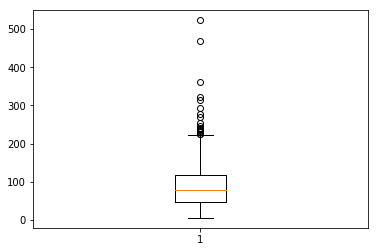

In [6]:
import matplotlib
% matplotlib inline
matplotlib.pyplot.boxplot(twt_length1)

In [7]:
print(statistics.mean(twt_length1))
print(statistics.median(twt_length1))

82.96694444444445
78.0


**In Wörtern**

In [8]:
tknzr = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

In [9]:
import html
def convert_html_emojis(corpus):
    new_corpus = []
    for text in corpus:
        text = html.unescape(text)
        new_corpus.append(text)
    return new_corpus

In [10]:
def get_tokens(texts):
    token_doc_list = []
    token_list = []
    emoji_list = []
    texts = convert_html_emojis(texts)
    for text in texts:
        
        tokens = tknzr.tokenize(text)
        tokens2 = []
        for token in tokens:
            token = re.sub(r'([1234567890!"#$%&()*+,./:@;?[\]^`{|}_~\t\n])', '', token)
            if token != '':
                tokens2.append(token)
                
        tmp_tokens = []
        for i, token in enumerate(tokens2):
            if token in UNICODE_EMOJI:
                emoji_list.append(token)

                #emoji_one = emoji.demojize(token)
                #emoji_one = emoji_one[1:-1]
                #emoji_all = re.split('_', emoji_one)

                #tokens[i] = emoji_all
                token_list.extend(token)
                tmp_tokens.extend(token)
            elif token == "i'd":
                token_list.extend(['i', 'would'])
                tmp_tokens.extend(['i', 'would'])
            else: 
                token_list.append(token)
                tmp_tokens.append(token)


        token_doc_list.append(tmp_tokens) 
    return token_list, token_doc_list, emoji_list

In [11]:
token_list, token_doc_list, emoji_list = get_tokens(texts)

In [12]:
twt_length_words=[]
for doc in token_doc_list:
    twt_length_words.append(len(doc))

{'whiskers': [<matplotlib.lines.Line2D at 0x2016f055c50>,
 'caps': [<matplotlib.lines.Line2D at 0x2016f034860>,
 'boxes': [<matplotlib.lines.Line2D at 0x2016f055b00>],
 'medians': [<matplotlib.lines.Line2D at 0x2016f069940>],
 'fliers': [<matplotlib.lines.Line2D at 0x2016f069c88>],
 'means': []}

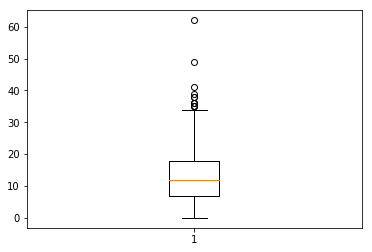

In [13]:
import matplotlib
% matplotlib inline
matplotlib.pyplot.boxplot(twt_length_words)

In [14]:
import statistics
print(statistics.mean(twt_length_words))
print(statistics.median(twt_length_words))

12.766277777777777
12.0


In [15]:
len(set(texts)) == len(texts)

True

### Types und Tokens

In [16]:
len(token_list)

229793

In [17]:
type_cnt = Counter()  
for type_ in token_list:
    type_cnt[type_] += 1
len(type_cnt)

21543

In [18]:
import operator

sorted_types = sorted(dict(type_cnt).items(), key=operator.itemgetter(1), reverse=True)
yaxis = dict(sorted_types).values()
xaxis = dict(sorted_types).keys()
len(xaxis)

21543

In [19]:
l = [i for i in range(len(xaxis))]

In [20]:
len(l)

21543

In [21]:
#list(yaxis)

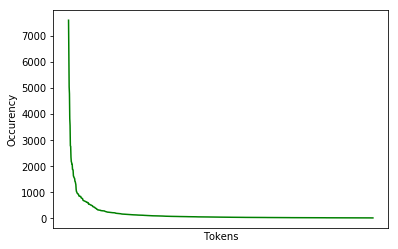

In [22]:
import matplotlib.pyplot as plt
plt.plot(l[:1000], list(yaxis)[:1000], color='g')
plt.xlabel('Tokens')
plt.ylabel('Occurency')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.title('')
plt.show()

In [23]:
len(emoji_list)

3909

In [24]:
emoji_cnt = Counter()  
for type_ in emoji_list:
    emoji_cnt[type_] += 1
emoji_dict = dict(emoji_cnt)

In [25]:
emoji_one = emoji.demojize(list(emoji_dict.keys())[0])
emoji_one = emoji_one[1:-1]
emoji_all = re.split('_', emoji_one)

### Nach Klassenverteilung

In [27]:
texts = np.asarray(texts)
labels = np.asarray(labels)
indices  = np.argsort(labels)
texts=texts[indices] 
labels=labels[indices]

In [28]:
class2d = texts[-cnt[2]:]
class1d = texts[cnt[0]:cnt[0]+cnt[1]]
class0d = texts[:cnt[0]]

class2l = labels[-cnt[2]:]
class1l = labels[cnt[0]:cnt[0]+cnt[1]]
class0l = labels[:cnt[0]]

In [29]:
def get_twt_length(texts_f):
    twt_length_f = []
    for text in texts_f:
        twt_length_f.append(len(text))
    return twt_length_f

In [30]:
def get_cnt(token_list):
    type_cnt = Counter()  
    for type_ in token_list:
        type_cnt[type_] += 1
    return len(type_cnt)

**Klasse auswählen**: class0d (hate), class1d (offensive), class2d (neutral).

In [37]:
class_c = class2d

In [38]:
token_list2, token_doc_list2, emoji_list2 = get_tokens(class_c)

In [39]:
char_2 = get_twt_length(class_c.tolist())
word_2 = get_twt_length(token_doc_list2)
emoji_cnt2 = get_cnt(emoji_list2)
type_cnt2 = get_cnt(token_list2)

print("Types:", type_cnt2, "Tokens:", len(token_list2))
print("Emojitypes", emoji_cnt2, "Emojitokens:", len(emoji_list2))
print("Durchschn. Länge in Buchstaben:", statistics.mean(char_2))
print("Durchschn. Länge in Wörtern:", statistics.mean(word_2))

Types: 13148 Tokens: 80372
Emojitypes 153 Emojitokens: 673
Durchschn. Länge in Buchstaben: 88.83683333333333
Durchschn. Länge in Wörtern: 13.395333333333333


In [47]:
token_list_c, token_doc_list_c, emoji_list_c = get_tokens(class_c)

In [41]:
type_cnt_c = Counter()  
for type_ in token_list_c:
    type_cnt_c[type_] += 1
len(type_cnt_c)

12382

In [42]:
import operator

sorted_c = sorted(dict(type_cnt_c).items(), key=operator.itemgetter(1), reverse=True)

In [43]:
sorted_c

[('you', 9405),
 ('a', 3992),
 ('cunt', 3805),
 ('your', 2273),
 ('the', 2217),
 ('are', 1988),
 ('i', 1876),
 ('u', 1871),
 ('to', 1857),
 ('retarded', 1597),
 ('and', 1475),
 ('faggot', 1301),
 ('is', 1216),
 ('retard', 1158),
 ('twat', 1107),
 ('of', 1051),
 ('fucking', 1046),
 ('that', 1041),
 ('fuck', 930),
 ('in', 902),
 ('me', 821),
 ('like', 818),
 ('😂', 796),
 ('\\', 790),
 ('it', 785),
 ('for', 706),
 ('on', 704),
 ('ur', 626),
 ('what', 615),
 ('be', 603),
 ('my', 602),
 ('up', 602),
 ('nigger', 568),
 ('have', 568),
 ('just', 566),
 ('not', 553),
 ('this', 527),
 ('get', 524),
 ('so', 485),
 ('do', 478),
 ('no', 472),
 ('off', 454),
 ('with', 437),
 ('rt', 433),
 ('ass', 416),
 ('go', 399),
 ('bitch', 387),
 ('was', 386),
 ('if', 376),
 ('all', 362),
 ('shit', 359),
 ('how', 340),
 ('as', 339),
 ('why', 328),
 ('white', 324),
 ('can', 322),
 ('know', 319),
 ('he', 318),
 ('or', 316),
 ('but', 312),
 ("'", 310),
 ('stupid', 305),
 ('about', 303),
 ('at', 301),
 ('lol', 290),